In [2]:
import numpy as np
import bayesflow as bf

# Principle Bayesian Workflow for Cognitive Modeling with SSMS and BayesFlow

 In this tutorial, we go through the steps of a [principled Bayesian workflow](https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html) for developing and applying cognitive models. To demonstrate this workflow, we simulate some cognitive processes using the [Sequential Sampling Model Simulators (SSMS)](https://lnccbrown.github.io/ssm-simulators/api/ssms/), the simulator backbone for the [Hierarchical Sequential Sampling Model (HSSM) toolbox](https://lnccbrown.github.io/HSSM/). From the simulated data, we perform Amortized Bayesian inference using [BayesFlow](https://bayesflow.org).

## Simulator

We start with the basic simulator from the HSSM toolbox.

In [3]:
from ssms.basic_simulators.simulator import simulator as ssm_sim

In [4]:
def ddm_simulator(
        v=None, a=None, z=None, t=None,
        n_samples: int = 1
):
    
    ddm_sim = ssm_sim(model="ddm", theta=dict(v=v, a=a, z=z, t=t), n_samples=n_samples)

    rts = ddm_sim['rts'].astype(np.float32)
    choices = ddm_sim['choices'].astype(np.float32)

    return dict(rts=rts, choices=choices)

## Priors

Next, we will sample some priors from some distribution, as follows:

\begin{equation}
v \sim \mathrm{Gamma}(2, 0.8), \; a \sim \mathrm{Gamma}(10, 0.2), \; z \sim \mathrm{Beta}(2, 2), \; t \sim \mathrm{Gamma}(1.5, 0.2).
\end{equation}

In [5]:
def priors(rng=None):

    if rng is None:
        rng = np.random.default_rng()

    drift = rng.gamma(2, 0.8)
    threshold = rng.gamma(10, 0.2)
    bias = rng.beta(2, 2) * threshold
    ndt = rng.gamma(1.5, 0.2)

    return {'v': drift, 'a': threshold, 'z': bias, 't': ndt}

In [6]:
theta = priors()
theta

{'v': 1.3459693523266063,
 'a': 2.450009346689626,
 'z': 1.1466581403952365,
 't': 0.32801162087163327}

## Putting everything together

After specifying the simulator and priors, we would wrap them together using BayesFlow's `make_simulator` function.

In [7]:
simulator = bf.make_simulator([priors, ddm_simulator])

In [8]:
draws = simulator.sample(batch_size=2)

In [9]:
print(draws['v'].shape)
print(draws['t'].shape)
print(draws['rts'].shape)
print(draws['choices'].shape)

(2, 1)
(2, 1)
(2, 1, 1)
(2, 1, 1)


## Prior Predictive Checks

To make sure that we are sampling the priors properly, BayesFlow has a pretty nice visual inspection in its `diagnostics` module that allows us to observe the samples directly.

In [10]:
prior_samples = simulator.simulators[0].sample(500)

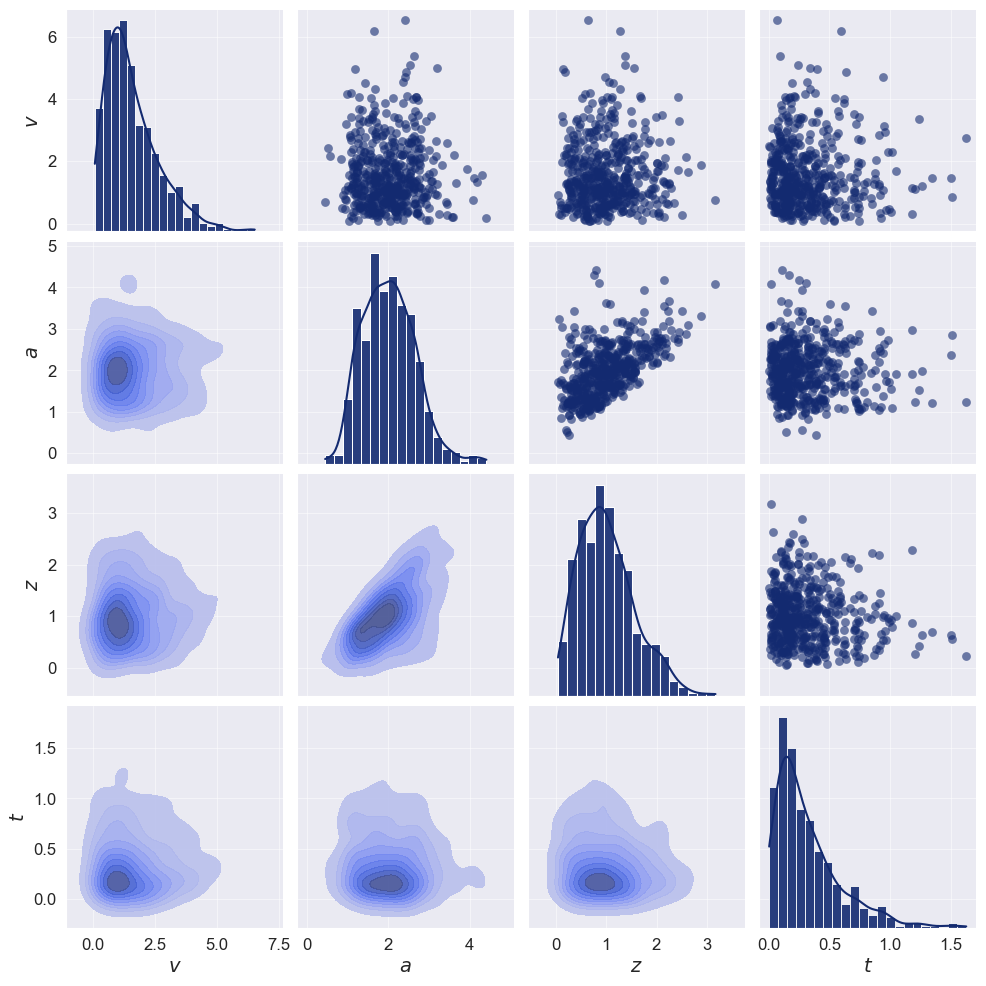

In [13]:
prior_grid = bf.diagnostics.plots.pairs_samples(
    samples=prior_samples, variable_names=[r'$v$', r'$a$', r'$z$', r'$t$']
)

## Adapter

To make sure that the simulated data and priors all friendly to the neural approximator, we use BayesFlow's `Adapter` to transform the data into summary variables and inference variables.

In a nutshell, from the perspective of the neural approximator:

* **Summary variables** are simulated data, and
* **Inference variables** are the parameters.

In [23]:
adapter = (
    bf.adapters.Adapter()
    .convert_dtype('float64', 'float32')
    .concatenate(['v', 'a', 'z', 't'], into="inference_variables")
    .concatenate(['rts', 'choices'], into="summary_variables")
)

In [24]:
adapter

Adapter([0: ConvertDType -> 1: Concatenate(['v', 'a', 'z', 't'] -> 'inference_variables') -> 2: Concatenate(['rts', 'choices'] -> 'summary_variables')])

We can inspect the transformed data after wrapping the simulation in the adapter to process.

In [27]:
adapted_sims = adapter(simulator.sample(10))

In [28]:
print(adapted_sims['summary_variables'].shape)
print(adapted_sims['inference_variables'].shape)

(10, 1, 2)
(10, 4)


## Neural approximator

The neural approximator is essentially a two-stage generative neural network consisting of a **summary network** and an **inference network**.

* **Summary network** takes the simulated data (*summary variables*) directly as inputs, and compress it into some latent summary statistics,
* **Inference network** takes the summary statistics as inputs, and infers the parameters (*inference variables*) from them.

In [31]:
summary_net = bf.networks.SetTransformer(summary_dim=32)

In [32]:
inference_net = bf.networks.FlowMatching()

## Workflow

BayesFlow makes everything easier by wrapping the amortization into a `Workflow` object. Here, we can simply use a `BasicWorkflow` object that bring together the simulator, the adapter, the summary network, and the inference network.

In [33]:
workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    summary_network=summary_net,
    inference_network=inference_net
)

In [35]:
%%time 
_ = workflow.simulate(32)

CPU times: total: 31.2 ms
Wall time: 34.7 ms


## Training

Using the `BasicWorkflow` object, we can generate training data and validation data for training the neural approximator.

In [37]:
training_data = workflow.simulate(10000)
validation_data = workflow.simulate(500)

In [38]:
history = workflow.fit_offline(
    data=training_data,
    epochs=200,
    batch_size=64,
    validation_data=validation_data
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.
C:\Users\Gerald Wong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\ops\nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (64, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Epoch 1/200


C:\Users\Gerald Wong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\ops\nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
C:\Users\Gerald Wong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\ops\nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - loss: 3.5172 - loss/inference_loss: 3.5172 - val_loss: 1.1201 - val_loss/inference_loss: 1.1201
Epoch 2/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 1.2448 - loss/inference_loss: 1.2448 - val_loss: 1.1558 - val_loss/inference_loss: 1.1558
Epoch 3/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 1.0866 - loss/inference_loss: 1.0866 - val_loss: 0.9659 - val_loss/inference_loss: 0.9659
Epoch 4/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 1.0049 - loss/inference_loss: 1.0049 - val_loss: 0.9672 - val_loss/inference_loss: 0.9672
Epoch 5/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.9976 - loss/inference_loss: 0.9976 - val_loss: 1.0187 - val_loss/inference_loss: 1.0187
Epoch 6/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.9748 - loss/inference_loss: 0.9748 - val_loss: 0.9931 - val_loss/inference_loss: 0.9931
Epoch 7/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.9660 - loss/inference_loss: 0.9660 

## Diagnostics

The `Workflow` object also gather all the diagnostics functionality that BayesFlow has to offer.

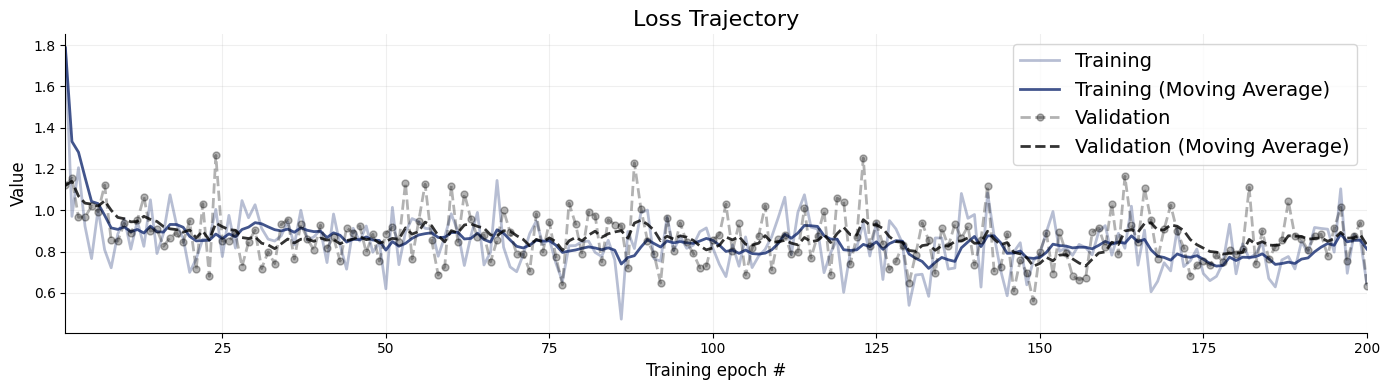

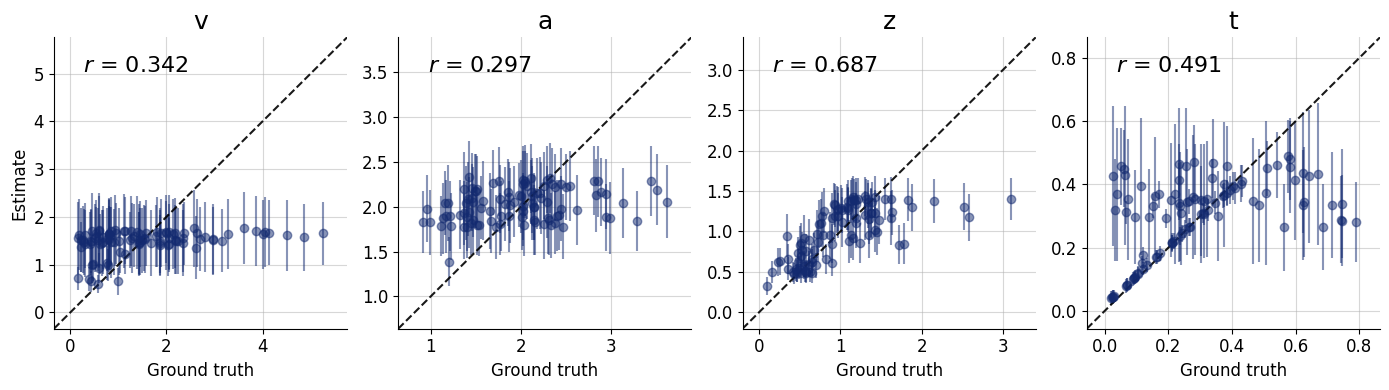

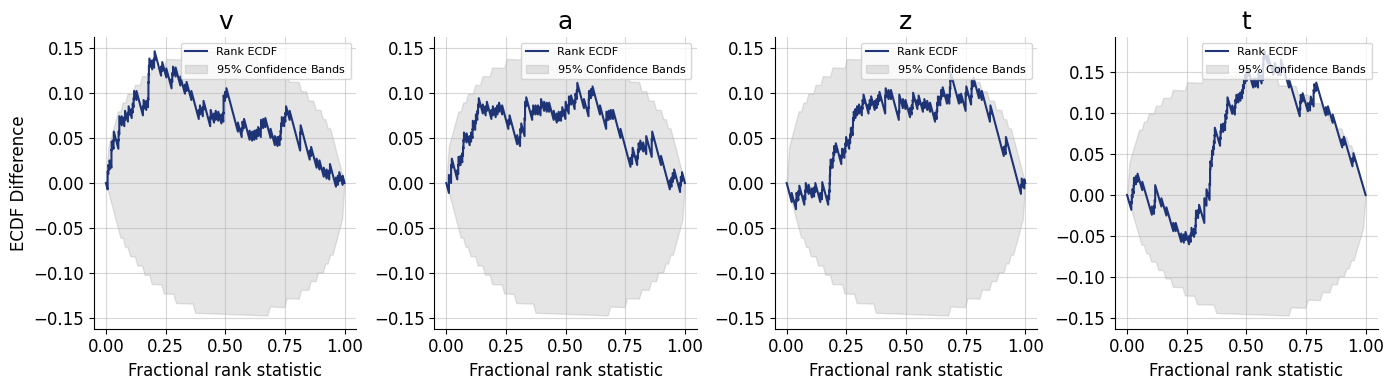

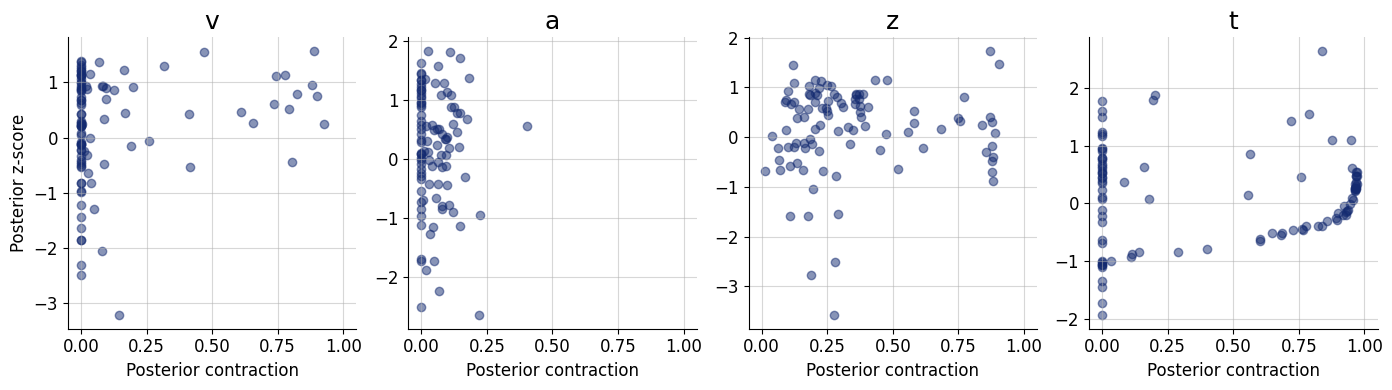

In [45]:
figures = workflow.plot_default_diagnostics(
    test_data=100,
    loss_kwargs={"figsize": (14, 4), "label_fontsize": 12},
    recovery_kwargs={"figsize": (14, 4), "label_fontsize": 12},
    calibration_ecdf_kwargs={"figsize": (14, 4), "legend_fontsize": 8, "difference": True, "label_fontsize": 12},
    z_score_contraction_kwargs={"figsize": (14, 4), "label_fontsize": 12}    
)

More materials coming soon...